In [1]:
import pandas as pd
from rich import print

In [2]:
catfile = '../gfcat/catalog/gfcat_object_table.csv'
vcatfile = '../gfcat/catalog/gfcat_visit_table.csv'
# Note that GFCAT includes a visit-level table that provides the eclipse numbers
# But we're going to pretend it doesn't exist for now so that we can show how to
#  search for eclipses from source positions in order to build the gPhoton2 input.
catdata = pd.read_csv(catfile)
vcatdata = pd.read_csv(vcatfile)

# Get the position and eclipse of the 5 most dramatic eclipse-like observations from GFCAT
vcatdata["mag_diff"] = pd.to_numeric(vcatdata["mag_diff"], errors="coerce")
objs = vcatdata[vcatdata['morphology']=='E'].nlargest(3,'mag_diff')
objs[['eclipse','ra','dec','simbad_otype','mag_diff']]

,eclipse,ra,dec,simbad_otype,mag_diff
632,15733,189.763271,65.825880,**,4.151942
628,15449,162.750488,5.425298,EclBin,3.057187
368,9900,135.096777,43.803453,blue,3.041757


In [3]:
from gPhoton.search.core import galex_cone_search
? galex_cone_search

Signature:
 galex_cone_search(
    ra: float,
    dec: float,
    arcseconds=2250,
    legs=False,
    aspect_dir: None | str | pathlib.Path = None,
)
Docstring:
This search function provides information on _possible_ observational coverage
of the provided source position (RA and Dec in decimal degrees) by looking for time
ranges in which the spacecraft boresight position as defined in the refine aspect
table falls within 0.625 degrees (or 2250 arcsecs) of the source position.

The returned values (in a pandas DataFrame) include eclipse number, object type,
the min/max RA/Dec of the boresight during the eclipse, and the FUV detector
temperature (used in calibration).
File:      ~/github/gPhoton2/gPhoton/search/core.py
Type:      function

In [4]:
# Let's find all the visits to each of the GFCAT objects above
for ra,dec in objs[['ra','dec']].values:
    visits = galex_cone_search(ra,dec)
    # `observed_legs` is the algorithmically determined number of visit legs (distinct from planned) using only aspect data
    # `ok_exposure_time` is the algorithmically estimated raw exposure time for the visit (including all legs) using only aspect data
    print(visits[['eclipse','plan_type','observed_legs','ok_exposure_time']])

eclipse plan_type  observed_legs  ok_exposure_time
1892      3976       AIS           13.0            1315.0
6358      9252       GII            1.0            1102.0
11696    15732       GII            1.0            1259.0
11697    15733       GII            1.0            1547.0
16540    21081       GII            1.0            1353.0
21692    26866       GII            1.0            1461.0
21693    26867       GII            1.0            1473.0

eclipse plan_type  observed_legs  ok_exposure_time
11443    15449       GII            1.0            1573.0
11591    15605       AIS           12.0            1245.0
15966    20459       AIS           12.0            1283.0
25386    31263       MIS            1.0            1699.0
29898    36378       MIS            1.0            1632.0

eclipse plan_type  observed_legs  ok_exposure_time
6836      9900       MIS            1.0            1641.0
15194    19631       AIS           12.0            1324.0
15820    20312       AIS           12.0            1273.0

gPhoton2 accepts an input catalog formatted as a `csv` file with the required columns of:
| Column Name | Units | Definition |
|-------------|-------|------------|
| `eclipse`   | #     | GALEX orbital eclipse number (count) |
| `ra`        | decimal degrees | Source or target right ascension (J2000) |
| `dec`       | decimal degrees | Source or target declination (J2000) |

Other columns can be present, but they will simply be ignored by gPhoton2.

> Note: This is major a change in behavior from `gPhoton1`, which would accept a source position _only_, and then automatically process all available data for that position. `gPhoton2` always requires an eclipse number. If an eclipse number is given with no target catalog, it will identify and extract photometry for all sources in the eclipse. If a target catalog is given, then it will extract photometry only at the locations and times specified, with any automated source detection.

In [5]:
# Construct the input catalog
# Limit our search to only MIS-like observations (==1 leg and >=600 seconds raw exposure)
testcat_frames = []
for ra,dec in objs[['ra','dec']].values:
    visits = galex_cone_search(ra,dec)
    visits_filtered = visits[(visits['observed_legs']==1) & (visits['ok_exposure_time']>=600)]
    visits_filtered['ra'] = ra
    visits_filtered['dec'] = dec
    testcat_frames.append(visits_filtered[['eclipse','ra','dec','ok_exposure_time']])
    #print(visits_filtered[['eclipse','plan_type','observed_legs','ok_exposure_time']])
testcat = pd.concat(testcat_frames, ignore_index=True)
testcat.to_csv('test_catalog.csv')
testcat

,eclipse,ra,dec,ok_exposure_time
0,9252,189.763271,65.825880,1102.0
1,15732,189.763271,65.825880,1259.0
2,15733,189.763271,65.825880,1547.0
3,21081,189.763271,65.825880,1353.0
4,26866,189.763271,65.825880,1461.0
5,26867,189.763271,65.825880,1473.0
6,15449,162.750488,5.425298,1573.0
7,31263,162.750488,5.425298,1699.0
8,36378,162.750488,5.425298,1632.0
9,9900,135.096777,43.803453,1641.0


In [6]:
from gPhoton.pipeline import execute_pipeline
? execute_pipeline

Signature:
 execute_pipeline(
    eclipse: int,
    band: Literal['NUV', 'FUV'],
    depth: int | None = None,
    threads: int | None = None,
    local_root: str = 'test_data',
    remote_root: str | None = None,
    download: bool = True,
    recreate: bool = False,
    verbose: int = 2,
    source_catalog_file: str | None = None,
    write: Mapping = mappingproxy({'image': True, 'movie': True}),
    aperture_sizes: Sequence[float] = (12.8,),
    lil: bool = True,
    coregister_lightcurves: bool = False,
    stop_after: Literal['photonpipe', 'moviemaker'] | None = None,
    compression: Literal['none', 'gzip', 'rice'] = 'gzip',
    hdu_constructor_kwargs: Mapping = mappingproxy({}),
    min_exptime: float | None = None,
    photometry_only: bool = False,
    burst: bool = False,
    chunksz: int = 1000000,
    share_memory: bool | None = None,
    extended_photonlist: bool = False,
    extended_flagging: bool = False,
    aspect: Literal['aspect', 'aspect2'] = 'aspect',
    override

In [7]:
# For demonstration purposes, we will process only e09900. Note that eclipse is required as a parameter,
#  and the catalog file that we just wrote is referenced for source positions. All matching source positions
#  will be extracted.
# The first time this runs, it will download the raw6 files from MAST. Total runtime will be ~2 minutes
#  with good internet and an ok computer.
for eclipse in [9900]:
    for band in ['NUV','FUV']:
        execute_pipeline(
            eclipse, # GALEX orbital eclipse number
            band, # GALEX band of "[NF]UV"
            depth=120, # movie frame / light curve integration
            # integer; None to deactivate (default None)
            threads=3,
            # where to both write output data and look for input data
            #local_root=, # default with be test_data/
            # auxiliary remote location for input data
            # remote_root="/mnt/s3",
            recreate=True,
            source_catalog_file="test_catalog.csv",
            # list of floats; relevant only to lightcurve / photometry portion
            aperture_sizes=[12.8], # radius in arcseconds
            # actually write image/movie products? otherwise hold in memory but
            # discard (possibly after performing photometry).
            write={"movie": True, "image": True},
            coregister_lightcurves=True, # Matches lightcurve timestamps across bands --- eases analysis
            # photonpipe, moviemaker, None (default None) --- useful for development and debugging
            stop_after=None,
            # only produce photometry and no other outputs
            photometry_only=False,
            # "none", "gzip", "rice" compression scheme
            compression="rice",
            # use array sparsification on movie frames?
            lil=True,
            # write movie frames as separate files
            burst=False, # debugging mode that produces a lot of very short integration images
            extended_photonlist=True, # write the equivalent of GALEX extended photon files (aka x-files)
            extended_flagging=False, # detect and flag extended sources, only in detection mode
            verbose=4,
            #single_leg=1, # process only the specified leg
            #photonlist_cols=
        )


starting timer
eclipse 9900 NUV  -- MIS; 1 leg(s)
trange= ( 794154802.995 , 794156446.995 )                   
RA AVG: 134.97855035635288, DEC AVG: 43.69282325770655, ROLL AVG: 189.01098600651508
Loading raw6 file...                                        
29331587 events
Unpacking raw6 data...                                      
stim_coef0, stim_coef1 = -146495.12203013658, 0.000190895080128859
                                                            
Runtime statistics:
 runtime		=	11.34 sec. = (0.19 min.)
  processed	   =   29159371 of 29331587 events.
rate		=	2587554.41 photons/sec.

11.53 elapsed seconds, restarting timer
Cross-band frame coregistration requested, but exposure time table at this depth for FUV was not found.
making images from test_data/e09900/e09900-nd-b00.parquet
indexing data and making WCS solution
making full-depth image
making count image frame
making artifact mask image frame
making dose map image frame
making row std image frame
making mean row image f

In [9]:
%matplotlib inline
import pdr # the [planetary data reader](https://github.com/millionconcepts/pdr); astropy also works.
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from gPhoton.io.fits_utils import read_wcs_from_fits # convenience function
from gPhoton.coords.wcs import make_wcs

In [19]:
fn = 'test_data/e09900/e09900-nd-ffull-b00-image-r.fits'
read_wcs_from_fits(fn,hdu=1)[1][0]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN'
CUNIT : 'deg' 'deg'
CRVAL : 134.960604311028 43.6922313331529
CRPIX : 1550.5 1536.0
PC1_1 PC1_2  : 1.0 0.0
PC2_1 PC2_2  : 0.0 1.0
CDELT : -0.000416666666666667 0.000416666666666667
NAXIS : 3100  3071

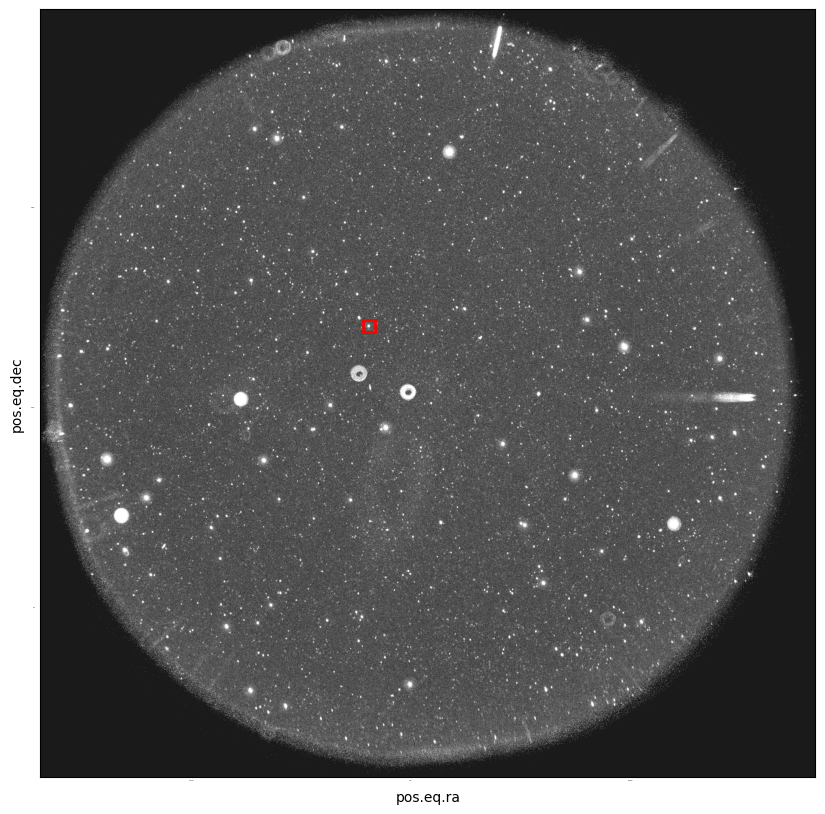

In [21]:
from matplotlib.patches import Rectangle
import numpy as np
import astropy.units as u
import pdr
from astropy.coordinates import SkyCoord


fn = 'test_data/e09900/e09900-nd-ffull-b00-image-r.fits'
data = pdr.read(fn)

ra, dec = 135.096777, 43.803453

wcs = read_wcs_from_fits(fn,hdu=1)[1][0]

imgband='NUV'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(ZScaleInterval()(data['COUNT']),
          cmap="Greys_r", origin="lower",alpha=.9)
# Note that pixel coordinates are assumed to be 0 at the center of the first pixel in each dimension.
# `world_to_pixel` requires a (1,1) pixel offset compared to the outputs of photutils --- idkmiddi
# x_nuv,y_nuv = wcs.world_to_pixel(SkyCoord(ra=ra_nuv,dec=dec_nuv,unit=u.deg))
# x_fuv,y_fuv = wcs.world_to_pixel(SkyCoord(ra=ra_fuv,dec=dec_fuv,unit=u.deg))
# ax.plot(x_nuv+1,y_nuv+1,'y.',alpha=0.2,markersize=6)

coord = SkyCoord(ra=ra, dec=dec, unit=u.deg)
x, y = wcs.world_to_pixel(coord)
box_size = 50
rect = Rectangle((x - box_size/2, y - box_size/2), box_size, box_size, 
                 linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_xticks([]);ax.set_yticks([]);

# for i in np.unique(catalog_ix_masked):
#     ix = np.where(catalog_ix_masked==i)
#     if len(ix[0])<=4: # This appears to be the threshhold at which it's all edge effects
#         if type(i) is np.ma.core.MaskedConstant:
#             continue
#         ax.plot(x_nuv[i]+1,y_nuv[i]+1,'bo',markersize=10)
#         ax.plot(x_fuv[ix]+1,y_fuv[ix]+1,'yo')

# ax.set_xlim([800,1000]);ax.set_ylim([800,1000]);




---

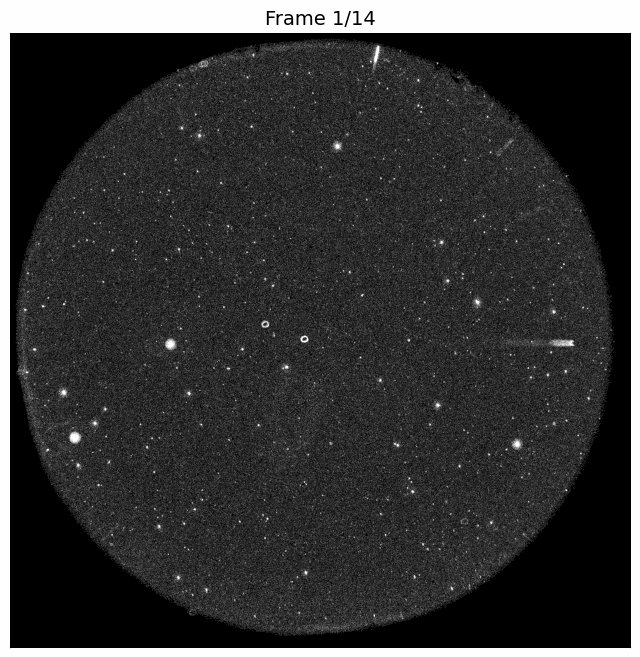

In [ ]:
import imageio.v2 as imageio
import tempfile, os

fn = 'test_data/e09900/e09900-nd-f0120-b00-movie-r.fits'
movie = pdr.read(fn)
cnt = movie['COUNT']
n_frames = cnt.shape[0]

tmpdir = tempfile.mkdtemp()
for i in range(n_frames):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(ZScaleInterval()(cnt[i]), origin='lower', cmap='Greys_r')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'Frame {i+1}/{n_frames}', fontsize=14)
    fig.savefig(os.path.join(tmpdir, f'{str(i).zfill(3)}.png'), bbox_inches='tight')
    plt.close(fig)

gif_path = os.path.join(tmpdir, 'animation.gif')
with imageio.get_writer(gif_path, mode='I', fps=4, loop=0) as writer:
    for i in range(n_frames):
        writer.append_data(imageio.imread(os.path.join(tmpdir, f'{str(i).zfill(3)}.png')))

from IPython.display import Image, display
display(Image(gif_path))


In [ ]:
import numpy as np

Index(['ra', 'dec', 'xcentroid', 'ycentroid', 'extended_source', 'xcenter',
       'ycenter', 'aperture_sum', 'artifact_flag', 'dose_col', 'dose_row',
       'ya_aperture_sum', 'stdcolrow_aperture_sum', 'q_aperture_sum',
       'exptime', 'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2',
       'aperture_sum_3', 'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6',
       'aperture_sum_7', 'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10',
       'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13', 'expt_0',
       'expt_1', 'expt_2', 'expt_3', 'expt_4', 'expt_5', 'expt_6', 'expt_7',
       'expt_8', 'expt_9', 'expt_10', 'expt_11', 'expt_12', 'expt_13', 't0_0',
       't0_1', 't0_2', 't0_3', 't0_4', 't0_5', 't0_6', 't0_7', 't0_8', 't0_9',
       't0_10', 't0_11', 't0_12', 't0_13', 't1_0', 't1_1', 't1_2', 't1_3',
       't1_4', 't1_5', 't1_6', 't1_7', 't1_8', 't1_9', 't1_10', 't1_11',
       't1_12', 't1_13', 'artifact_flag_0', 'artifact_flag_1',
       'artifact_flag_2', 'artifact_flag_3', 'artifact_flag_4',
       'artifact_flag_5', 'artifact_flag_6', 'artifact_flag_7',
       'artifact_flag_8', 'artifact_flag_9', 'artifact_flag_10',
       'artifact_flag_11', 'artifact_flag_12', 'artifact_flag_13'],
      dtype='str')

<ErrorbarContainer object of 3 artists>

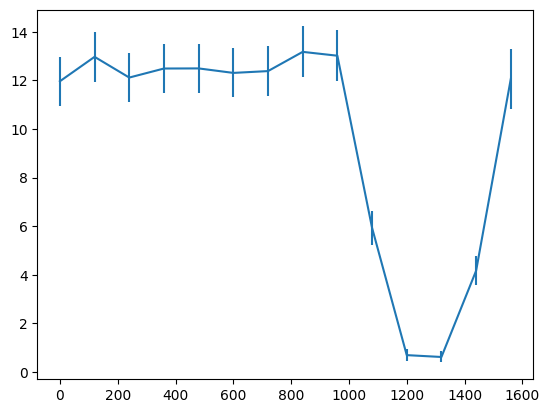

In [ ]:
photom = pd.read_csv('test_data/e09900/e09900-nd-f0120-b00-movie-photom-12_8.csv')
print(photom.keys())

# construct the light curves from the photometry file
t = [photom[f't0_{n}'][0] for n in range(14)]
expt = [photom[f'expt_{n}'][0] for n in range(14)]
aperture_sum = [photom[f'aperture_sum_{n}'][0] for n in range(14)]

plt.errorbar(np.array(t)-np.min(t),np.array(aperture_sum)/np.array(expt),
             yerr=3*np.sqrt(aperture_sum)/np.array(expt),)

In [ ]:
data['COUNT_HEADER']

<MultiDict('XTENSION': 'IMAGE', 'BITPIX': -32, 'BITPIX_comment': 'data type of original image', 'NAXIS': 3, 'NAXIS_comment': 'dimension of original image', 'NAXIS1': 3100, 'NAXIS1_comment': 'length of original image axis', 'NAXIS2': 3071, 'NAXIS2_comment': 'length of original image axis', 'NAXIS3': 14, 'NAXIS3_comment': 'length of original image axis', 'PCOUNT': 0, 'GCOUNT': 1, 'EXTNAME': 'COUNT', 'TELESCOP': 'GALEX', 'ECLIPSE': 9900, 'LEG': 0, 'BANDNAME': 'NUV', 'BAND': 1, 'TIMESYS': 'UTC', 'TIMEUNIT': 's', 'DATE-BEG': '2005-03-06T14:33:23', 'DATE-END': '2005-03-06T15:01:23', 'MJD-BEG': 53435.6065162037, 'MJD-END': 53435.6259606481, 'TSTART': 794154803.995, 'TSTOP': 794156483.995, 'TELAPSE': 1680.0, 'XPOSURE': 1480.173, 'T0_0': 794154803.995, 'T1_0': 794154923.995, 'EXPT_0': 107.484, 'T0_1': 794154923.995, 'T1_1': 794155043.995, 'EXPT_1': 107.822, 'T0_2': 794155043.995, 'T1_2': 794155163.995, 'EXPT_2': 108.091, 'T0_3': 794155163.995, 'T1_3': 794155283.995, 'EXPT_3': 108.261, 'T0_4': 7